# Tinkering with RTT histogram timeseries

Timeseries of per site daily aggregate statistics of counts per histogram bins.
Most queries are "GROUP BY partition_date, metro"

NB: For some reason "restart and execute all" hangs.
Following a restart, it works better to run cells one at a time.

## Setup

See ./README.md

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import matplotlib.ticker
import datetime
import collections
import pickle
# Depends on: pip install --upgrade google-cloud-bigquery
from google.cloud import bigquery

# Some matplotlib features are version dependent.
assert(matplotlib.__version__ >= '2.1.2')
print "Done"

Done


# Global flags

Invoke cell individually or reorder them to change defaults

In [2]:
EndDate = '2018-05-13'
project = 'mlab-sandbox'
dataset_id = 'mattmathis'

In [3]:
# Skip slow/expensive queries
DoQueries=False

In [4]:
# Force queries
DoQueries=True

In [5]:
# Enable interactive figures that pan and zoom
interactive = True

In [6]:
# Enables figures to load inline in the browser and saved (github etc).
interactive = False

In [8]:
# Enable plots for the paper
DoPaper = True

In [34]:
# Disable plots for the paper
DoPaper = False

In [9]:
def setupmatplotlib(force=None):
    global interactive
    if force == 'inline':
        %matplotlib inline
        return
    elif force == 'interactive':
        %matplotlib
        return
    elif force is not None:
        print 'Unknown option, using default'
    if interactive:
        print 'default interactive'
        %matplotlib
        return
    else:
        print 'default inline'
        %matplotlib inline
        return
setupmatplotlib()

default inline


In [10]:

def run_query(query, project=project, trial_run=False, **kwargs):
    """ run_query
        Yields a DataFrame from a query string
        Accepts nested {parameter} substitutions.
        
        Stashes forensic output in globals.
    """
    global DebugQuery # For pasting into BQ, after the fact
    global NumberedQuery # For grocking BQ error line numbers.
    global DefaultArgs # To ignore some

    # Only allow argument substitution 4 levels deep, because
    # accidental infinite recursion risks crashing the notebook.
    args = DefaultArgs.copy()
    args.update(kwargs)
    query=query.format(**args)
    query=query.format(**args)
    query=query.format(**args)
    query=query.format(**args)
    if '{' in query:
        raise "Unexpanded substitutions"
    
    # Leave crumbs if we need a postmortem
    DebugQuery = query
    NumberedQuery = ""
    for i, l in enumerate(query.split('\n')):
          NumberedQuery += "%3d %s\n"%(i, l)
    if trial_run:
        print "trial_run"
        return None

    # do the work
    client = bigquery.Client(project=project)
    job = client.query(query)  # All errors are delayed

    # Marshal the results, catching async errors
    try:
        results = collections.defaultdict(list)
        for row in job.result(timeout=300):
            for key in row.keys():
                results[key].append(row.get(key)) 
    except:
        print NumberedQuery
        raise

    return pd.DataFrame(results, index=pd.DatetimeIndex(results['partition_date']))
print "Done"

Done


In [11]:
def unlog(x, pos):
    v = math.pow(10, x)
    frac, whole = math.modf(v)
    if frac > 0:
        return '%.1f' % v
    else:
        return '%d' % whole

logFormatter = matplotlib.ticker.FuncFormatter(unlog)
print "Done"

Done


## Query templates for most of the plots below
Unidirectional with selected percentiles

In [23]:
# All of these queries yield timeseries of multidimensional histograms of 'value'

# Query the list of beacons
BeaconQ ="""
SELECT
  clientIP {beacon_fields}
FROM
  `{dataset_id}.master_annotations`
WHERE
  clientIP NOT IN (
    '64.40.187.69', '50.249.4.153', '208.77.130.154', # Abusive clients
    '62.197.243.133', '68.186.181.130', # Abusive clients
    '45.56.98.222',
    '64.9.225.99',
    '64.9.225.190' ) # exclude eb, etc
    {beacon_where}
"""

# Query relevant fields of the beacons of interest
# This yields one row per test
# with download rate (Mb/s) in column 'value'
DownloadQ="""
SELECT
  partition_date,
  web100_log_entry.connection_spec.remote_ip AS clientIP,
  connection_spec.data_direction AS direction,
  web100_log_entry.connection_spec.local_ip AS local_ip,
  IFNULL(SUBSTR(connection_spec.server_hostname, -25, 5),
         "UNK") AS server_site,
  IFNULL(SUBSTR(connection_spec.server_hostname, -25, 3),
         "UNK") AS server_metro,
  web100_log_entry.log_time AS test_time,
  web100_log_entry.snap.duration AS duration,
  web100_log_entry.snap.HCDataOctetsOut AS bytes_transfered,
  {more_data}
  SAFE_DIVIDE(web100_log_entry.snap.HCDataOctetsOut, web100_log_entry.snap.duration) * 8 AS value
FROM
  `measurement-lab.release.ndt_all`
WHERE
  connection_spec.data_direction = 1
  AND web100_log_entry.snap.duration > 10000
  AND web100_log_entry.snap.HCDataOctetsOut > 0
  AND web100_log_entry.snap.HCDataOctetsOut < 1625000000
  {data_where}
  AND partition_date <= '{enddate}' 
"""

# Query relevant fields of the beacons of interest
# This yields one row per test
# with upload rate (Mb/s) in column 'value'
UploadQ="""
SELECT
  partition_date,
  web100_log_entry.connection_spec.remote_ip AS clientIP,
  connection_spec.data_direction AS direction,
  web100_log_entry.connection_spec.local_ip AS local_ip,
  IFNULL(SUBSTR(connection_spec.server_hostname, -25, 5),
         "UNK") AS server_site,
  IFNULL(SUBSTR(connection_spec.server_hostname, -25, 3),
         "UNK") AS server_metro,
  web100_log_entry.log_time AS test_time,
  web100_log_entry.snap.duration AS duration,
  web100_log_entry.snap.HCDataOctetsIn AS bytes_transfered,
  {more_data}
  SAFE_DIVIDE(web100_log_entry.snap.HCDataOctetsIn, web100_log_entry.snap.duration) * 8 AS value
FROM
  `measurement-lab.release.ndt_all`
WHERE
  connection_spec.data_direction = 0
  AND web100_log_entry.snap.duration > 10000
  AND web100_log_entry.snap.HCDataOctetsIn > 0
  AND web100_log_entry.snap.HCDataOctetsIn < 1625000000
  {data_where}
  AND partition_date <= '{enddate}' 
"""

# Query relevant fields of the beacons of interest
# This yields one row per test
# with RTT in column 'value'
RTTQ="""
SELECT
  partition_date,
  web100_log_entry.connection_spec.remote_ip AS clientIP,
  connection_spec.data_direction AS direction,
  web100_log_entry.connection_spec.local_ip AS local_ip,
  IFNULL(SUBSTR(connection_spec.server_hostname, -25, 5),
         "UNK") AS server_site,
  IFNULL(SUBSTR(connection_spec.server_hostname, -25, 3),
         "UNK") AS server_metro,
  web100_log_entry.log_time AS test_time,
  web100_log_entry.snap.duration AS duration,
  web100_log_entry.snap.HCDataOctetsOut AS bytes_transfered, 
  SAFE_DIVIDE(web100_log_entry.snap.SumRTT, web100_log_entry.snap.CountRTT) AS value
FROM
  `measurement-lab.release.ndt_all`
WHERE
  connection_spec.data_direction = 1
  AND web100_log_entry.snap.duration > 10000
  AND web100_log_entry.snap.HCDataOctetsOut > 0
  AND web100_log_entry.snap.HCDataOctetsOut < 1625000000
  {data_where}
  AND partition_date <= '{enddate}' 
"""

# Query relevant fields of the beacons of interest
# This yields one row per test
# with MinRTT in column 'value'
MinRTTQ="""
SELECT
  partition_date,
  web100_log_entry.connection_spec.remote_ip AS clientIP,
  connection_spec.data_direction AS direction,
  web100_log_entry.connection_spec.local_ip AS local_ip,
  IFNULL(SUBSTR(connection_spec.server_hostname, -25, 5),
         "UNK") AS server_site,
  IFNULL(SUBSTR(connection_spec.server_hostname, -25, 3),
         "UNK") AS server_metro,
  web100_log_entry.log_time AS test_time,
  web100_log_entry.snap.duration AS duration,
  web100_log_entry.snap.HCDataOctetsOut AS bytes_transfered, 
  web100_log_entry.snap.MinRTT AS value
FROM
  `measurement-lab.release.ndt_all`
WHERE
  connection_spec.data_direction = 1
  AND web100_log_entry.snap.duration > 10000
  AND web100_log_entry.snap.HCDataOctetsOut > 0
  AND web100_log_entry.snap.HCDataOctetsOut < 1625000000
  {data_where}
  AND partition_date <= '{enddate}' 
"""

# Joinclause
joinQ = """
    SELECT *
    FROM ( {data} )
    INNER JOIN ( {beacons} )
    USING ( clientIP )
"""

# Aggregate test statistics by partition_date and server_site
mainQ="""
#standardSQL
SELECT
  UNIX_DATE(partition_date) * 86400 AS partition_time,
  partition_date,
  server_site,
  ANY_VALUE(server_metro) AS server_metro,
  COUNTIF(value < 1.0) AS LT001,
  COUNTIF(value < 2.0) AS LT002,
  COUNTIF(value < 4.0) AS LT004,
  COUNTIF(value < 8.0) AS LT008,
  COUNTIF(value < 16.0) AS LT016,
  COUNTIF(value < 32.0) AS LT032,
  COUNTIF(value < 64.0) AS LT064,
  COUNTIF(value < 128.0) AS LT128,
  COUNTIF(value < 256.0) AS LT256,
  COUNTIF(value < 512.0) AS LT512,
  COUNT(*) AS count
FROM ( {joinclause} )
GROUP BY
  partition_date,
  server_site
ORDER BY
  partition_date
"""

global EndDate # pervent irrelevant changes
# Default values for optional parameters
DefaultArgs = {
    'beacons':BeaconQ,
    'beacon_fields':'',
    'beacon_where':'',
    'data':DownloadQ,
    'more_data':'',
    'data_where':'',
    'enddate':EndDate,
    'joinclause':joinQ,
    'dataset_id':dataset_id
}

# Useful debugging queries
CountQ="""
#standardSQL
SELECT
    count(*) AS count
FROM ( {counted} )
"""

LimitQ="""
#standardSQL
SELECT
    *
FROM ( {counted} ) LIMIT 10
"""

print "Done"

Done


In [24]:
# Test query for debugging rate and join
if False:
    testQ=CountQ
    print "beacons", run_query(testQ, counted=BeaconQ)
    print "download", run_query(testQ, counted=DownloadQ)
    print "lga", run_query(testQ, counted=DownloadQ, metro='nuq', 
                    data_where=" AND SUBSTR(connection_spec.server_hostname, -25, 3) = '{metro}' ")
    print "join", run_query(testQ, counted=joinQ)
    print "lga join", run_query(testQ, counted=joinQ, metro='nuq',
                    data_where=" AND SUBSTR(connection_spec.server_hostname, -25, 3) = '{metro}' ")

In [25]:
# Test query for debugging RTT
if False:
    test_data = run_query(mainQ, beacons=BeaconQ, data=RTTQ, metro='nuq', 
                          data_where=" AND SUBSTR(connection_spec.server_hostname, -25, 3) = '{metro}' ")
    print test_data[0:10]
    # print NumberedQuery

# Global Fleet Information

The first cell below was generated by MiscSmallQueries, which extracts the data from the sites spreadsheet.

The second cell below was manaully generated to help tell some stories.

In [26]:
# Sites with missing region fields ['']
contenents = {'Europe': ['vie', 'bcn', 'ham', 'trn', 'svg', 'dub', 'lis', 'fra', 'ath', 'beg', 'lba', 'prg', 'par', 'lhr', 'lca', 'mil', 'ams', 'lju', 'bru', 'arn', 'mad'], 'Oceania': ['wlg', 'syd', 'akl'], 'South_America': ['fln', 'bog'], 'Africa': ['acc', 'jnb', 'tnr', 'nbo', 'tun', 'los', 'mpm'], 'Asia': ['tpe', 'mnl', 'hnd', 'bkk', 'sin', 'bom'], 'North_America': ['yqm', 'den', 'yvr', 'mia', 'iad', 'atl', 'lga', 'nuq', 'ywg', 'yyc', 'lax', 'yul', 'sea', 'sjc', 'ord', 'yyz', 'dfw']}
# Sites with missing transit fields ['', 'lga0t', 'iad0t', 'iad1t']
transits = {'Serbian Open eXchange': ['beg01'], 'Level 3': ['fra04', 'mad02'], 'go6': ['lju01'], 'Tata': ['bom02', 'mia03', 'ord03', 'lax02', 'sin01', 'nuq04', 'lga03', 'dfw02', 'atl03', 'sea02', 'iad03'], 'Internap': ['atl06', 'ams07', 'sjc01', 'lga07', 'dfw06', 'sea06'], 'Hurricane Electric': ['yul02', 'yul01', 'yyz02', 'yyc01', 'yyz01', 'yvr01', 'yyc02', 'yqm01', 'ywg01'], 'PHOpenIX': ['mnl01'], 'Biglobe': ['hnd02'], 'ISC': ['nuq02'], 'Vodafone': ['ams05', 'arn02', 'lis02', 'bru01', 'mil05', 'lhr04', 'par05', 'prg05', 'fra03'], 'Ghana IXP': ['acc02', 'acc01'], 'CAT Telecom': ['bkk01'], 'Victoria University of Wellington': ['wlg01'], 'AARNET': ['syd01'], 'Telia': ['mad03', 'arn01', 'arn04', 'lhr02', 'ams03', 'par01', 'fra01', 'mil02', 'ham01', 'prg03', 'bru03', 'par03'], 'RNP (ASN 1916) and FAPESC (ASN 52950).': ['fln01'], 'Tinet': ['mad01', 'mil01'], 'Altibox': ['svg01'], 'Zayo': ['dfw05', 'mia05', 'ord05', 'lga06', 'den04', 'nuq06', 'lax05'], 'Vocus': ['syd02'], 'Leaseweb': ['ams06'], 'XO': ['dfw04', 'atl05', 'den03', 'nuq05', 'sea05', 'iad01'], 'WIDE': ['hnd01'], 'REANNZ': ['akl01', 'wlg02'], 'CyNet': ['lca01'], 'Ubuntunet': ['nbo01'], 'RTR': ['vie01'], 'Nigeria IXP': ['los01'], 'Cogent': ['ord02', 'mia02', 'dfw01', 'atl02', 'sea01', 'nuq03', 'lax01', 'iad02', 'lga02'], 'CATNIX / Orange': ['bcn01'], 'GTT': ['ams04', 'lhr03', 'mia04', 'prg04', 'arn05', 'mad04', 'par04', 'lax03', 'ord04', 'fra02', 'sea03', 'atl04', 'mil03', 'lga04', 'den01', 'iad04', 'bru04'], 'Airtel': ['bom01'], 'aql': ['lba01'], 'National Chi Nan University': ['tpe01'], 'ATI': ['tun01'], 'Voxel': ['lga01'], 'Google': ['nuq01'], 'Internap / Voxel': ['ams02'], 'Telecom Malagasy': ['tnr01'], 'Topix': ['trn01'], 'GRNET': ['ath01', 'ath02', 'ath03'], 'Tenet': ['jnb01'], 'HEanet': ['dub01'], 'Level3': ['lhr01', 'arn03', 'ams01', 'lhr05', 'mia01', 'lga05', 'lga1t', 'mil04', 'prg01', 'lax04', 'lis01', 'par02', 'atl01', 'bru02', 'dfw03', 'prg02', 'den02', 'sea04', 'iad05', 'ord01'], 'Telefonica': ['bog01'], 'Morenet': ['mpm01']}
cities = {'': '', 'prg': 'Prague', 'yyc': 'Calgary', 'vie': 'Vienna', 'bru': 'Brussells', 'nuq': 'San Jose', 'lba': 'Leeds', 'jnb': 'Johannesburg', 'yul': 'Montreal', 'mnl': 'Quezon City', 'sea': 'Seattle', 'ord': 'Chicago', 'arn': 'Stockholm', 'tpe': 'Taipei', 'fra': 'Frankfurt', 'ham': 'Hamburg', 'yvr': 'Vancouver', 'mia': 'Miami', 'iad': 'Washington', 'dfw': 'Dallas', 'los': 'Lagos', 'lis': 'Lisbon', 'sjc': 'San Jose', 'sin': 'Changi', 'lhr': 'London', 'yqm': 'Moncton', 'lga': 'New York', 'syd': 'Sydney', 'akl': 'Auckland', 'par': 'Paris', 'bkk': 'Bangkok', 'mpm': 'Maputo', 'lax': 'Los Angeles', 'mad': 'Madrid', 'tun': 'Tunis', 'lca': 'Nicosia', 'ams': 'Amsterdam', 'yyz': 'Toronto', 'mil': 'Milan', 'acc': 'Accra', 'bcn': 'Barcelona', 'hnd': 'Tokyo', 'tnr': 'Antananarivo', 'svg': 'Sola', 'atl': 'Atlanta', 'trn': 'Turin', 'beg': 'Belgrade', 'ath': 'Athens', 'ywg': 'Winnipeg', 'bom': 'Mumbai', 'den': 'Denver', 'fln': 'Florian\xc3\xb3polis', 'nbo': 'Nairobi', 'wlg': 'Wellington', 'lju': 'Ljubljana', 'dub': 'Dublin', 'bog': 'Bogota'}

In [27]:
# Manual metro sets
USAmetros = ['lga', 'den', 'iad', 'dfw', 'ord', 'lax', 'sea', 'nuq']


# Testing area
Paste experimental query and plotting below.  When done, move to the proper section

In [28]:
# Updated to support cohort ending dates
def query_global_cohort(clist=None, cohort=None, coend=None, pmode=0, data=DownloadQ, query=mainQ, **kwargs):
    """
    pmode:
        0: All data and beacons
        1: All beacons, excluding beacons for which the predicate is True
        2: Only beacons for which the predicate is True
        -1: All data, excluding data for which the predicate is True
        -2: Only data for which the predicate is True
    """
    global contenents
    res = {}
    bw = ''
    if cohort:
        print 'Cohort:', cohort
        bw = ' AND series_start_asc < "{cohort} 00:00:00.000 UTC"'
        if coend:
            print 'Cohort end:', coend
            bw = bw + ' AND series_end_asc > "{coend} 00:00:00.000 UTC"'
    if pmode > 0:
        t = ' AND %s ( {predicate} ) '%('' if (pmode == 2) else 'NOT')
        print "Beacons predicate:", t.format(**kwargs)
        bw = bw + t
    dw = ' AND SUBSTR(connection_spec.server_hostname, -25, 3) in ( {metros} ) '
    if pmode < 0:
        t = ' AND %s ( {predicate} ) '%('' if (pmode == -2) else 'NOT')
        print "Data predicate:", t.format(**kwargs)
        dw = dw + t    
        
    for contenent in clist:
        metros = str(list(contenents[contenent]))[1:-1]
        print contenent+" ...",
        res[contenent] = run_query(query, data=data,
                            metros=metros, cohort=cohort, coend=coend, beacon_where=bw, data_where=dw,
                            **kwargs)
        try:
            print len(res[contenent]), sum(res[contenent]['count']) # Number of metro-days, total tests
        except:
            print "Summary stats failed"
    return res

# Test queries
if False:
    predicate = 'REGEXP_CONTAINS(ClientType, "BT")'
    NA_withBT = query_global_cohort(['North_America'], '2010-06-01', '2018-01-01',
                                    predicate=predicate, pmode=0)['North_America']
    NA_withoutBT = query_global_cohort(['North_America'], '2010-06-01', '2018-01-01',
                                    predicate=predicate, pmode=1)['North_America']
    NA_onlyBT = query_global_cohort(['North_America'], '2010-06-01', '2018-01-01',
                                    predicate=predicate, pmode=2)['North_America']

if False:
    test_data = query_global_cohort(['Africa'], '2015-06-01')
    test_rtt = query_global_cohort(['Africa'], data=RTTQ)
print 'Done'

Done


In [29]:
# Plots for the paper

PaperDir = './'
PaperDir = '../paper/'
if False:
    %matplotlib
    base='Africa'
    globaldata = contenent_data_all[base].resample('W').sum()
    for c in list(contenents):
        if c == base:
            continue
        tmp = pd.DataFrame(contenent_data_all[c]).resample('W').sum()
        globaldata, tmp = globaldata.align(tmp, fill_value=0)
        globaldata += tmp
    paper_geo_rates(contenent_data_all['Europe'].resample('W').sum(), 
                    ofile=PaperDir+'Europe.png', figsize=(6, 6))
    paper_geo_rates(globaldata,
                    ofile=PaperDir+'Global.png', nrows=1, figsize=(6, 3))
    paper_geo_rates(contenent_data_all['North_America'].resample('W').sum(),
                    ofile=PaperDir+'NorthAmerica.png', nrows=1, figsize=(6, 3))
   
print 'Done'

Done


In [30]:
# Force inline plotting
interactive=False

# Plot RTT
Query and Plot RTT data
Computed from MinRR and SumRTT/CountRTT

Note that some of the graphs are labled "Mb/s" which should be "ms".
e.g. "percentages above 1, 4, 16, 64 and 256 ms".

Note that down to the right is good (smaller percentages above the target RTT).

In [31]:
if DoQueries:
    contenent_rtt_all = query_global_cohort(contenents, data=RTTQ)
print 'Done'

Europe ... 52495 30280557
Oceania ... 8878 4076039
South_America ... 1157 267787
Africa ... 8744 729605
Asia ... 8366 3594866
North_America ... 85184 53140695
Done


In [32]:
if DoQueries:
    contenent_minrtt_all = query_global_cohort(contenents, data=MinRTTQ)
print 'Done'

Europe ... 52495 30280557
Oceania ... 8878 4076039
South_America ... 1157 267787
Africa ... 8744 729605
Asia ... 8366 3594866
North_America ... 85184 53140695
Done


In [33]:

def plot_geo_RTT(raw_data, ofile=None, geos=None, ncols=2,
                 title=None, field=None, figsize=(16, 20)):
    global cities
    names = ['Counts per RTT Bracket', 'pct less than 4, 8, 16, 32, 64, 128, 256 and 512 mS']
    stats = ['LT004', 'LT008', 'LT016', 'LT032', 'LT064', 'LT128', 'LT256', 'LT512', "count"]
    cnames = ['>4 mS', '>8 mS', '>16 mS', '>32 mS', '>64 mS', '>128 mS', '>256 mS', '>512 mS', "One"]
#    stats = ['LT001', 'LT004', 'LT016', 'LT064', 'LT256', "count"]
#    cnames = ['N001', 'N004', 'N016', 'N064', 'N256', "One"]

    if geos == None:
        geos = list(raw_data)
        print geos
        
    fig, axes = plt.subplots(squeeze=False, nrows=len(geos), ncols=ncols,
                             sharex=True, figsize=figsize)
   
    for axes, geo, iy in zip(axes,geos,range(len(geos))):

        # Force copying to prevent corrupting raw_data[] when re-executing bad code
        if field:
            data = pd.DataFrame(raw_data[raw_data[field] == geo], copy=True)
        else:
            if geo not in raw_data:
                print "Skipping", geo,
                print "from", str(list(raw_data))
                continue
            data = pd.DataFrame(raw_data[geo], copy=True)
        data.index = pd.DatetimeIndex(data['partition_date'])
        data = data.resample("W").sum()
    #   print data.describe

        # make it pretty
        for ax, name, ix in zip(axes,names[-ncols:],range(len(axes))):
            if geo in cities:
                ax.set_title("%s (%s) %s"%(cities[geo], geo, name))
            else:
                ax.set_title(geo+' '+name)
            ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
            ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))
            ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())
            ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter(''))
    #       ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter('     %m'))

            if iy < len(geos)-1:
                ax.set_xticklabels([])

        for s, n in zip(stats, cnames):
            data[n] = 100.0 - (100.0*data[s])/data['count']

        # data.plot(ax=axes[0], y=['count'], lw=1, legend=None)
        if ncols >1:
            data.plot(ax=axes[0], y=stats, lw=1, legend=True if iy == len(geos)-1 else None)
        data.plot(ax=axes[-1], y=cnames, lw=1, legend=None)
        axes[-1].set_ylim(0.0, 100.0)
        for ax in axes:
            ax.tick_params(axis='x', labelrotation=90)
    if title and not ofile:
        fig.suptitle(title, y='0.95', fontsize=14)
    if ofile:
        fig.savefig(ofile, dpi=100)
    else:
        plt.show()
    plt.close()
print 'Done'

Done


In [35]:
if DoPaper:
    plot_geo_RTT(contenent_minrtt_all, ofile='../paper/minRTT.png', ncols=1, figsize=(6, 6),
                 geos=['Europe','North_America'], title="minRTT Global overview")

['Europe', 'Oceania', 'South_America', 'Africa', 'Asia', 'North_America']


/usr/local/google/home/mattmathis/anaconda2/lib/python2.7/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


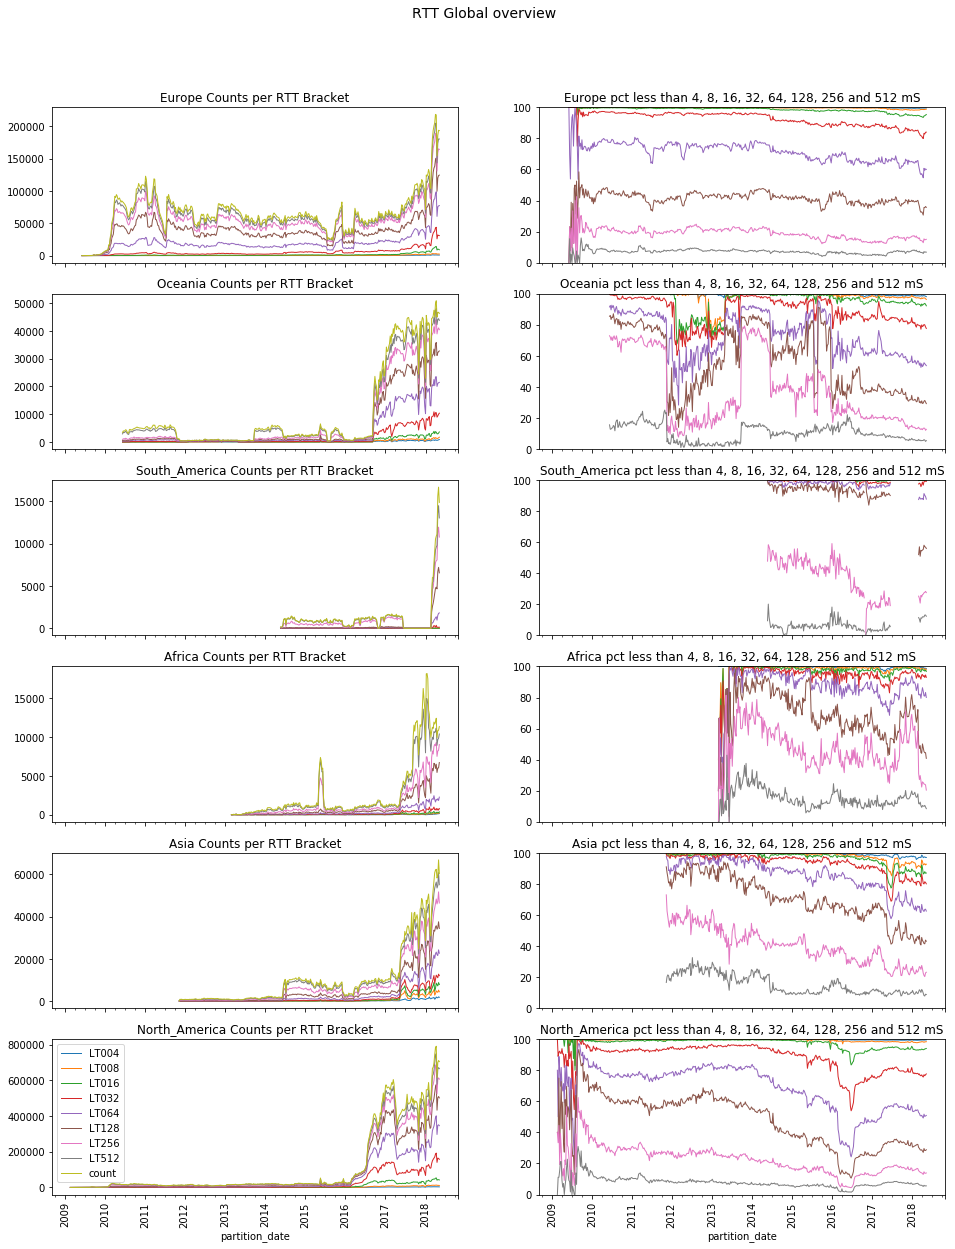

Done


In [36]:
# Global overview
plot_geo_RTT(contenent_rtt_all, title="RTT Global overview")
print 'Done'

['Europe', 'Oceania', 'South_America', 'Africa', 'Asia', 'North_America']


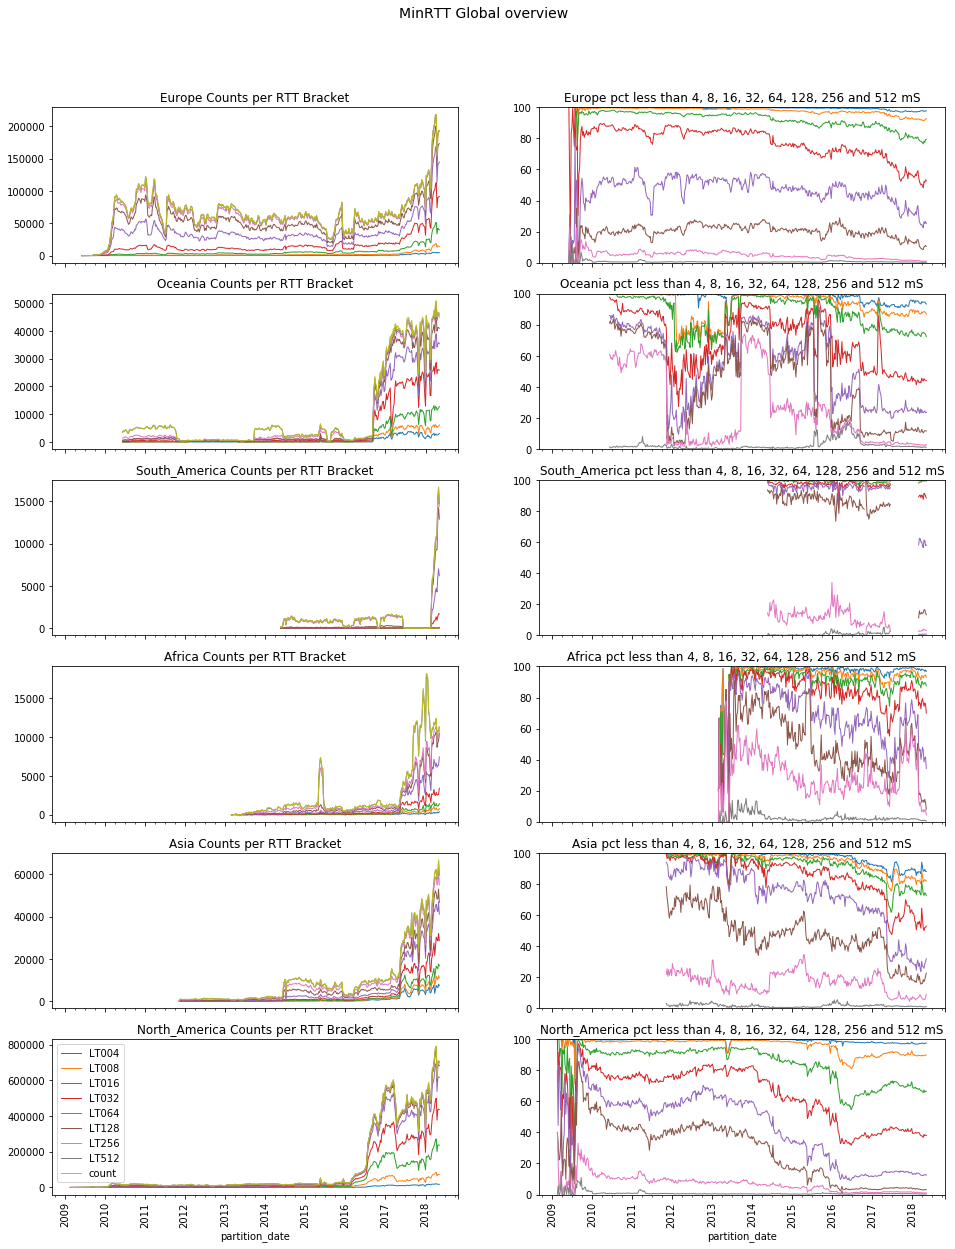

Done


In [37]:
# Global overview
plot_geo_RTT(contenent_minrtt_all, title="MinRTT Global overview")
print 'Done'